# Random Forest Classsification of the gas_price in ethereum network

### Introduction:
#### In this project, we are going to use random forest classifier to predict what price range should a user pay to have their transaction included in the ethereum blockchain.

In [172]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

# Transformers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Metrices
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, plot_confusion_matrix
# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


# Balancing the dataset
from imblearn.over_sampling import SMOTE

# visualize
from sklearn.tree import export_graphviz

### Data:
Data path:

In [2]:
sample_data_path = '../../data/Sample_Data.csv' 

In [3]:
sample_df = pd.read_csv(sample_data_path)

In [4]:
sample_df.head()

,Unnamed: 0,time_stamp,block_number,hash,gas_price,receipt_gas_used,totalfee,past_min,past_max,past_median,blck_med,blck_min,blck_max,blck_totalfee,blck_count,Eur_night,eth_high,Unnamed: 0.1
0,0,2020-10-01 00:00:31+00:00,10966876,0xfe04bf5504dadbbe3a42c7e0ff5c19df3cecbb0690dd...,75.0,46779,3508425.0,73.386952,197.470615,94.312484,75.9,66.000000,130.000001,9.158803e+08,184,0,369.286987,NaN
1,1,2020-10-01 00:02:53+00:00,10966884,0x86eb68f0a61cc2db2ade0106ce246b7c568723e89e7f...,90.0,112429,10118610.0,69.303340,267.901379,92.047103,84.0,75.000000,359.000000,1.324160e+09,168,0,369.286987,NaN
2,2,2020-10-01 00:02:53+00:00,10966884,0x9d0ba410c4938f1b0bbbae05509169b04a4f90cfccf4...,180.0,56209,10117620.0,69.303340,267.901379,92.047103,84.0,75.000000,359.000000,1.324160e+09,168,0,369.286987,NaN
3,3,2020-10-01 00:03:42+00:00,10966887,0xd2b0317b6a49f17974918f546615be29e9c782a42411...,73.0,26209,1913257.0,69.303340,267.901379,93.699142,75.0,70.000001,400.000000,1.260698e+09,223,0,369.286987,NaN
4,4,2020-10-01 00:03:47+00:00,10966888,0x40584bff51a203b97f28b6d2f83e2cbb3a8f2c706b00...,150.0,643648,96547200.0,69.303340,267.901379,90.304533,76.0,69.000100,500.000000,1.159260e+09,113,0,369.286987,NaN


In [155]:
sample_df.columns

Index(['Unnamed: 0', 'time_stamp', 'block_number', 'hash', 'gas_price',
       'receipt_gas_used', 'totalfee', 'past_min', 'past_max', 'past_median',
       'blck_med', 'blck_min', 'blck_max', 'blck_totalfee', 'blck_count',
       'Eur_night', 'eth_high', 'Unnamed: 0.1'],
      dtype='object')

### Clean the dataframe and categorize the features based on their dtypes.
#### Steps:
##### 1: Remove the unnecessary features like Unnamed: 0, time_stamp, and block_number features. 
##### 2. Find the categorize the numerical and categorical features.

In [21]:
sample_df.columns

Index(['Unnamed: 0', 'time_stamp', 'block_number', 'hash', 'gas_price',
       'receipt_gas_used', 'totalfee', 'past_min', 'past_max', 'past_median',
       'blck_med', 'blck_min', 'blck_max', 'blck_totalfee', 'blck_count',
       'Eur_night', 'eth_high', 'Unnamed: 0.1'],
      dtype='object')

In [22]:
drop_features = ['Unnamed: 0', 'time_stamp', 'block_number', 'hash', 
                 'Unnamed: 0.1', 'receipt_gas_used', 'totalfee','blck_med', 
                 'blck_min', 'blck_max', 'blck_totalfee', 'blck_count']
numerical_features = ['past_min', 'past_max', 'past_median', 'eth_high']
categorical_features = ['Eur_night','blck_count']

In [23]:
# This is the original copy of the data after removing the unnecessary data.
original_clean_data = sample_df.drop(drop_features, axis=1)

## Original state of data frame

In [24]:
original_clean_data.head()

,gas_price,past_min,past_max,past_median,Eur_night,eth_high
0,75.0,73.386952,197.470615,94.312484,0,369.286987
1,90.0,69.303340,267.901379,92.047103,0,369.286987
2,180.0,69.303340,267.901379,92.047103,0,369.286987
3,73.0,69.303340,267.901379,93.699142,0,369.286987
4,150.0,69.303340,267.901379,90.304533,0,369.286987


In [25]:
original_clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   gas_price    200000 non-null  float64
 1   past_min     200000 non-null  float64
 2   past_max     200000 non-null  float64
 3   past_median  200000 non-null  float64
 4   Eur_night    200000 non-null  int64  
 5   eth_high     196169 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 9.2 MB


In [26]:
# remove observations with na
original_clean_data.dropna(axis=0, inplace=True)

### Data for exploration

In [27]:
dds = sample_df.drop(drop_features, axis=1)

In [28]:
dds.dropna(axis=0, inplace=True)

In [29]:
dds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196169 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   gas_price    196169 non-null  float64
 1   past_min     196169 non-null  float64
 2   past_max     196169 non-null  float64
 3   past_median  196169 non-null  float64
 4   Eur_night    196169 non-null  int64  
 5   eth_high     196169 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 10.5 MB


In [30]:
scale = MinMaxScaler()
dds[numerical_features] = scale.fit_transform(dds[numerical_features])

## Get the labels from the different gas price ranges.
#### The ranges were taken from K-mean cluster. They are given as follows:
1. ranges_4_clusters = [177.91976034, 3000.0, 12699.05, 34912.02562252]
2. ranges_5_clusters = [129.88, 429.681, 3352.85825472, 12699.04775591, 34912.02562252]
3. ranges_6_clusters = [87.45000222, 196.802, 489.5, 3352.85825472, 12699.04775591, 34912.02562252]

In this part of the code, we will create different levels based on the ranges above. For each of the ranges, we will have one level. For example for ranges_4_clusters, we will have 4 labels. Ranges_5_cluster  and Ranges_6_cluster will have 5 and 6 ranges respectively.

#### The original dataset after scaled.
1. gas_price is the response variable
2. Everything else are the predictors.
3. We are going to break the gas_price into different labels to categorize different ranges for the gas_price.

In [31]:
dds.head()

,gas_price,past_min,past_max,past_median,Eur_night,eth_high
0,75.0,0.055161,0.012555,0.044918,0,0.015762
1,90.0,0.052092,0.017483,0.043667,0,0.015762
2,180.0,0.052092,0.017483,0.043667,0,0.015762
3,73.0,0.052092,0.017483,0.044579,0,0.015762
4,150.0,0.052092,0.017483,0.042704,0,0.015762


### Step 1: Get different labels for different gar_price ranges

In [32]:
    def create_categorize(data_frame: pd.DataFrame, feature: str, label: str, ranges: List[float]):
        """
        This function will create label based on the values in feature column.
        :param feature: The feature column that you want to use to create label.
        :param label: The label column that you want to create based on the values in feature column.
        :param ranges: The ranges of value in feature column that you want to use to create the label column.
        :return: Create a column in the dataframe called label.
        """
        data_frame = data_frame.copy(deep=True)
        if not len(ranges):
            raise ValueError("The ranges list is empty")
        for i, val in enumerate(ranges):
            if i == 0:
                data_frame.loc[data_frame[data_frame[feature] <= val].index, label] = str(i + 1)
                continue
            data_frame.loc[data_frame[(data_frame[feature] <= val) &
                                                (data_frame[feature] > ranges[i - 1])].index, label] = str(i + 1)
        data_frame = data_frame.drop([feature], axis=1)
        return data_frame.sort_index()

In [33]:
ranges_4_clusters = [177.91976034, 3000.0, 12699.05, 34912.02562252]
ranges_5_clusters = [129.88, 429.681, 3352.85825472, 12699.04775591, 34912.02562252]
ranges_6_clusters = [87.45000222, 196.802, 489.5, 3352.85825472, 12699.04775591, 34912.02562252]

In [34]:
df_4_cluster = create_categorize(dds, "gas_price", "label", ranges_4_clusters)
df_5_cluster = create_categorize(dds, "gas_price", "label", ranges_5_clusters)
df_6_cluster = create_categorize(dds, "gas_price", "label", ranges_6_clusters)

### Create a function that will summarize value counts for each of the labels

In [35]:
def count_summarize(data_frame: pd.DataFrame, label: str, data_frame_name: str):
    """
    This function will return a summary of label in the given dataframe. It will return their counts and ratios
    in the dataframe.
    """
    if label not in data_frame.columns:
        raise AttributeError(f"Feature {label} not found in the dataframe")
    counts = data_frame[label].value_counts()
    percents = counts.apply(lambda x: (x*100)/counts.sum())
    print(f"Counts of each label in {data_frame_name}:\n {counts}\n------------------")
    print(f"Percent of each label in {data_frame_name}:\n {percents}\n------------------")

### Show the count in the different groups for each cluster

In [36]:
count_summarize(df_4_cluster, 'label', 'df_4_cluster')
count_summarize(df_5_cluster, 'label', 'df_5_cluster')
count_summarize(df_6_cluster, 'label', 'df_6_cluster')

Counts of each label in df_4_cluster:
 1    169482
2     26614
3        64
4         9
Name: label, dtype: int64
------------------
Percent of each label in df_4_cluster:
 1    86.395914
2    13.566873
3     0.032625
4     0.004588
Name: label, dtype: float64
------------------
Counts of each label in df_5_cluster:
 1    148969
2     44318
3      2820
4        53
5         9
Name: label, dtype: int64
------------------
Percent of each label in df_5_cluster:
 1    75.939114
2    22.591745
3     1.437536
4     0.027018
5     0.004588
Name: label, dtype: float64
------------------
Counts of each label in df_6_cluster:
 1    115384
2     59381
3     19133
4      2209
5        53
6         9
Name: label, dtype: int64
------------------
Percent of each label in df_6_cluster:
 1    58.818672
2    30.270328
3     9.753325
4     1.126070
5     0.027018
6     0.004588
Name: label, dtype: float64
------------------


#### Summary of the labeling:

It looks like our data set is very imbalanced. For 4 cluster and 5 cluster data, we have the most imbalanced data.
More than 75% of the total data in 4 and 5 clusters belong to label 1. So, any machine learning model will have a problem with this type of dataset. We need to take care of the data imbalance problem in cluster 4 and 5. The problem is not as bad in cluster 6 but we will still need to balance the data to make sure there is no bias in the model.

#### Steps forward:
1. Select the proper cluster that is easier to balance the data in i.e we don't have as bad of the data imbalance problem as in other cluster. 
2. Balance the data in that cluster using methods like under sampling, oversampling, and SMOTE (Synthetic Minority Oversampling Technique.)
3. Use machine learning models for each on the data produced after applying data balancing techniques.

### Try different ranges
### Analysis:
#### Checking for transactions that are less than 1.0 gwei

After doing some analysis, I found that a very low ratio of transaction pay one on less gwei in transaction gas_price:


In [37]:
a_ranges = [1.0, 80.00, 250.00, 300.00, 34912.02562252]
new_cluster_df = create_categorize(original_clean_data, 'gas_price', 'label', a_ranges)
count_summarize(new_cluster_df, 'label', 'new_cluster_df')

Counts of each label in new_cluster_df:
 2    102987
3     77348
5      6449
1      5158
4      4227
Name: label, dtype: int64
------------------
Percent of each label in new_cluster_df:
 2    52.499121
3    39.429268
5     3.287472
1     2.629365
4     2.154775
Name: label, dtype: float64
------------------


# Modeling for 3 class labels

1. There are 3 classes we are using and they are [1.0, 80.00, 250.00, np.inf].
2. We are removing anything from 0 to 1 ether.
3. Everything from (1.0 - 80.00] is classified as class 2, (80.00 - 250.00] is classified as class 3.
3. Every ether value from 250.0 to max value is classified as class 4.

### Step 1: Cluster all the data into 4 classes.

In [171]:
inf_ranges = [1.0, 80.00, 300.00, np.inf]
inf_cluster_df = create_categorize(original_clean_data, 'gas_price', 'label', inf_ranges)
count_summarize(inf_cluster_df, 'label', 'inf_cluster_df')

Counts of each label in inf_cluster_df:
 2    102987
3     81575
4      6449
1      5158
Name: label, dtype: int64
------------------
Percent of each label in inf_cluster_df:
 2    52.499121
3    41.584042
4     3.287472
1     2.629365
Name: label, dtype: float64
------------------


### Step 2: Select the observations with label 2, 3, and 4 only i.e get all the labels except for 1

In [152]:
three_classes_new_df = inf_cluster_df[inf_cluster_df['label'] != '1']

In [153]:
three_classes_new_df.head()

,past_min,past_max,past_median,Eur_night,eth_high,label
0,73.386952,197.470615,94.312484,0,369.286987,2
1,69.303340,267.901379,92.047103,0,369.286987,3
2,69.303340,267.901379,92.047103,0,369.286987,3
3,69.303340,267.901379,93.699142,0,369.286987,2
4,69.303340,267.901379,90.304533,0,369.286987,3


### Step 3: Seperate the features and labels. Features in 'X' and labels in 'y'

In [41]:
X = three_classes_new_df.drop(['label'], axis=1)
y = three_classes_new_df['label']

### Step 4: Create train, test split.

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### Step 5: Model

In [196]:
three_class_rfc = RandomForestClassifier(n_estimators=10, min_samples_split=200, random_state=0)

In [197]:
three_class_rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=200, n_estimators=10, random_state=0)

In [185]:
##
dtc = DecisionTreeClassifier(min_samples_split=20000)

In [186]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=20000)

In [187]:
grph = tree.export_graphviz(dtc, out_file=None, 
                            feature_names=X_train.columns,
                            class_names=['2', '3', '4'],
                            filled=True, rounded=True,
                            special_characters=True)

In [177]:
import graphviz

In [190]:
graph = graphviz.Source(grph, format='png')

In [191]:
graph.render('eth_tree')

'eth_tree.png'

## Results:

### Accuracy score of the model


In [198]:
y_pred_train = three_class_rfc.predict(X_train)

In [199]:
print(classification_report(y_train, y_pred=y_pred_train))

/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.77      0.90      0.83     82389
           3       0.73      0.67      0.70     61878
           4       0.00      0.00      0.00      8541

    accuracy                           0.76    152808
   macro avg       0.50      0.52      0.51    152808
weighted avg       0.71      0.76      0.73    152808



/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


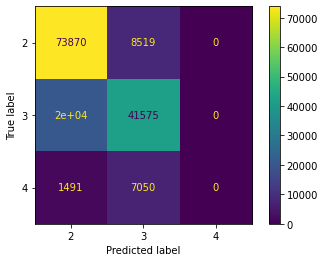

In [201]:
plot_confusion_matrix(three_class_rfc, X_train, y_train)
plt.show()

In [202]:
y_pred_test = three_class_rfc.predict(X_test)

In [204]:
print(classification_report(y_test, y_pred_test))

/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.76      0.89      0.82     20598
           3       0.71      0.66      0.69     15470
           4       0.00      0.00      0.00      2135

    accuracy                           0.75     38203
   macro avg       0.49      0.52      0.50     38203
weighted avg       0.70      0.75      0.72     38203



/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


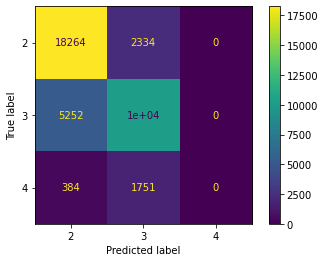

In [205]:
plot_confusion_matrix(three_class_rfc, X_test, y_test)
plt.show()

### Important features

In [206]:
three_class_rfc.feature_importances_

array([0.11273871, 0.11905283, 0.25169023, 0.00308957, 0.51342866])

In [208]:
imp_features_ratio = dict(zip(X_train.columns, three_class_rfc.feature_importances_))

In [214]:
for item in imp_features_ratio.items():
    print(f"{item[0]}:")

('past_min', 0.1127387063082512)
('past_max', 0.11905282675456996)
('past_median', 0.2516902311082346)
('Eur_night', 0.0030895714338154733)
('eth_high', 0.5134286643951288)


# Results Ends

In [87]:
accuracy_score(y_true=y_train, y_pred=y_pred_train)

0.7510536097586514

In [88]:
three_class_rfc.predict_proba(X_train).shape

(152808, 3)

### For test dataset

In [89]:
y_pred_test = three_class_rfc.predict(X_test)

In [90]:
print(classification_report(y_true=y_test, y_pred=y_pred_test))

              precision    recall  f1-score   support

           2       0.76      0.87      0.81     20598
           3       0.69      0.66      0.68     15470
           4       0.15      0.00      0.01      2135

    accuracy                           0.73     38203
   macro avg       0.54      0.51      0.50     38203
weighted avg       0.70      0.73      0.71     38203



In [91]:
accuracy_score(y_true=y_test, y_pred=y_pred_test)

0.7347328743815931

In [92]:
three_class_rfc.predict_proba(X_test)

array([[0.82402499, 0.16281711, 0.01315789],
       [0.95591802, 0.03777751, 0.00630447],
       [0.02763359, 0.8403626 , 0.13200382],
       ...,
       [0.61005481, 0.37859712, 0.01134806],
       [0.62789729, 0.36123315, 0.01086957],
       [0.56410658, 0.41124048, 0.02465293]])

### Important Features

In [94]:
print(three_class_rfc.feature_importances_)
print(three_classes_new_df.columns)

[0.04903413 0.04019903 0.59102987 0.00220632 0.31753064]
Index(['past_min', 'past_max', 'past_median', 'Eur_night', 'eth_high',
       'label'],
      dtype='object')


## Visualize

In [159]:
estimator = three_class_rfc.estimators_[0]

In [160]:
export_graphviz(estimator, out_file='tree.out',
                feature_names=X_train.columns, 
                class_names=['2', '3', '4'],
                rounded=True,
                proportion=False,
                precision=2,
                filled=True
               )

In [192]:
exp = tree.export_graphviz(estimator, out_file=None,
                feature_names=X_train.columns, 
                class_names=['2', '3', '4'],
                rounded=True,
                proportion=False,
                precision=2,
                filled=True
               )

In [193]:
gph2 = graphviz.Source(exp, format='png')
gph2.render('testone')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.583261 to fit


'testone.png'

In [195]:
X_test.head()

,past_min,past_max,past_median,Eur_night,eth_high
155561,116.749218,165.025856,133.553410,1,1467.784912
176619,79.305396,170.768456,102.741965,1,1861.356934
18718,55.386673,137.130573,84.972131,1,380.021515
119374,79.480502,121.086290,88.678723,1,786.798462
45733,27.618131,41.867290,34.473411,0,407.665649


# Modeling on the scaled data:
### Normalized data:

The past_min, past_max, and past_median are in gwei and eth_high is in dollar. So, we need to normalize the data to make sure that they are in the same scale. We are using the MinMaxScaler because standardizing the data would result in negative values which are valid for past_min, past_max, past-median, and eth_high.

In [149]:
# These are the features with numerical data
num_features = ['past_min', 'past_max', 'past_median', 'eth_high']

In [100]:
# Using the MinMaxScaler.
min_max_3_class_scaler = MinMaxScaler()
X_train[num_features] = min_max_3_class_scaler.fit_transform(X_train[num_features])

<ipython-input-100-3e05779a5fd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_features] = min_max_3_class_scaler.fit_transform(X_train[num_features])
/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [102]:
X_test[num_features] = min_max_3_class_scaler.transform(X_test[num_features])

<ipython-input-102-25725ce8f021>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[num_features] = min_max_3_class_scaler.transform(X_test[num_features])
/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [139]:
three_class_rfc_scalled = RandomForestClassifier(n_estimators=25, min_samples_split=300, random_state=0)

In [140]:
three_class_rfc_scalled.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=300, n_estimators=25, random_state=0)

In [142]:
y_pred_scaled_train = three_class_rfc_scalled.predict(X_train)

In [143]:
print(classification_report(y_pred=y_pred_scaled_train, y_true=y_train))

              precision    recall  f1-score   support

           2       0.77      0.89      0.83     82389
           3       0.72      0.67      0.70     61878
           4       0.67      0.00      0.00      8541

    accuracy                           0.75    152808
   macro avg       0.72      0.52      0.51    152808
weighted avg       0.75      0.75      0.73    152808



In [144]:
three_class_rfc_scalled.feature_importances_

array([0.13524408, 0.09337741, 0.24235324, 0.00269888, 0.52632638])

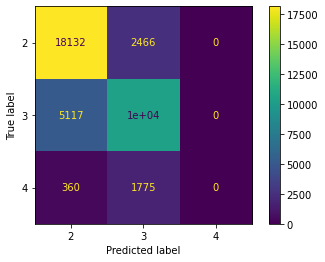

In [145]:
plot_confusion_matrix(three_class_rfc_scalled, X_test, y_test)
plt.show()

In [146]:
y_pred_test = three_class_rfc_scalled.predict(X_test)

In [150]:
print(classification_report(y_true=y_test, y_pred=y_pred_test))

/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.77      0.88      0.82     20598
           3       0.71      0.67      0.69     15470
           4       0.00      0.00      0.00      2135

    accuracy                           0.75     38203
   macro avg       0.49      0.52      0.50     38203
weighted avg       0.70      0.75      0.72     38203



/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sagarshahi/.envs/ether/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ------------------------This portion is for the testing purposes----------------------------------

In [69]:
two_class_less_predictors = two_class_new_df.drop(['blck_totalfee', 'blck_count'], axis=1)

In [70]:
X = two_class_less_predictors.drop('label', axis=1)
y = two_class_less_predictors['label']

### Data Balancing using SMOTE

In [71]:
smote = SMOTE(sampling_strategy='minority')

In [72]:
X_sm, y_sm = smote.fit_resample(X, y)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm) 

#### Scale the data using MinMaxScaler

In [74]:
min_max_scaler = MinMaxScaler()

In [75]:
print(numerical_features)

['past_min', 'past_max', 'past_median', 'blck_med', 'blck_min', 'blck_max', 'blck_totalfee', 'eth_high']


In [76]:
new_numerical_features = ['past_min', 'past_max', 'past_median', 'blck_med', 'blck_min', 
                          'blck_max', 'eth_high']

In [77]:
X_train[new_numerical_features] = min_max_scaler.fit_transform(X_train[new_numerical_features])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [78]:
X_test[new_numerical_features] = min_max_scaler.transform(X_test[new_numerical_features])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### Model

In [79]:
min_max_random_forest_classifier = RandomForestClassifier(n_estimators=200, min_samples_split=400, random_state=0)

In [80]:
min_max_random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=400, n_estimators=200, random_state=0)

In [81]:
min_max_random_forest_classifier.score(X_train, y_train)

0.7875578805551678

In [82]:
min_max_random_forest_classifier.score(X_test, y_test)

0.7840029129748756

In [83]:
y_pred_train = min_max_random_forest_classifier.predict(X_train)

In [84]:
y_pred_test = min_max_random_forest_classifier.predict(X_test)

In [47]:
def get_measurement_matrices(true_values, predicted_values, positive_level):
    precision = precision_score(true_values, predicted_values, pos_label=positive_level)
    recall = recall_score(true_values, predicted_values, pos_label=positive_level)
    f1 = f1_score(true_values, predicted_values, pos_label=positive_level)
    print(f"Precision score: {precision} \n")
    print(f"Recall score: {recall} \n")
    print(f"F1 score: {f1} \n")

In [85]:
get_measurement_matrices(y_train, y_pred_train, '2')

Precision score: 0.7591642509434994 

Recall score: 0.8423333211957907 

F1 score: 0.7985892154380797 



In [86]:
get_measurement_matrices(y_test, y_pred_test, '2')

Precision score: 0.7549019607843137 

Recall score: 0.8411010777745412 

F1 score: 0.7956737393221274 



## Two class with some removed features

In [87]:
reduced_forest = RandomForestClassifier(n_estimators=200, min_samples_split=400, random_state=0)

In [88]:
X_train.head()

,past_min,past_max,past_median,blck_med,blck_min,blck_max,Eur_night,eth_high
153602,0.082541,0.014417,0.090784,0.045060,0.007141,0.002971,0,0.778368
31785,0.020931,0.001789,0.012265,0.005730,0.014353,0.000481,0,0.029769
53066,0.021449,0.002203,0.012509,0.009377,0.019994,0.000948,1,0.081201
193974,0.053496,0.006893,0.037426,0.020500,0.051599,0.000454,0,0.664654
139028,0.035597,0.005037,0.028081,0.017712,0.044271,0.000638,1,0.614097


In [89]:
X_train_red = X_train.drop(['blck_med', 'blck_min','blck_max'], axis=1)
X_test_red = X_test.drop(['blck_med', 'blck_min','blck_max'], axis=1)

In [98]:
X_train_red.head()

,past_min,past_max,past_median,Eur_night,eth_high
153602,0.082541,0.014417,0.090784,0,0.778368
31785,0.020931,0.001789,0.012265,0,0.029769
53066,0.021449,0.002203,0.012509,1,0.081201
193974,0.053496,0.006893,0.037426,0,0.664654
139028,0.035597,0.005037,0.028081,1,0.614097


In [90]:
reduced_forest.fit(X_train_red, y_train)

RandomForestClassifier(min_samples_split=400, n_estimators=200, random_state=0)

In [91]:
y_pred_red_train = reduced_forest.predict(X_train_red)

In [92]:
get_measurement_matrices(y_train, y_pred_red_train, '2')

Precision score: 0.7531562577890482 

Recall score: 0.8435470754591026 

F1 score: 0.7957931137141746 



In [93]:
y_pred_red_test = reduced_forest.predict(X_test_red)

In [94]:
get_measurement_matrices(y_test, y_pred_red_test, '2')

Precision score: 0.7500970287636379 

Recall score: 0.8444509175648122 

F1 score: 0.7944823806152511 



## This is for more than 2 classes

In [97]:
three_ranges = [1.0, 50.00, 100.00, 150.00, 300.00, 34912.02562252]
new_cluster_df = create_categorize(original_clean_data, 'gas_price', 'label', a_ranges)
count_summarize(new_cluster_df, 'label', 'new_cluster_df')

Counts of each label in new_cluster_df:
 2    102987
3     77348
5      6449
1      5158
4      4227
Name: label, dtype: int64
------------------
Percent of each label in new_cluster_df:
 2    52.499121
3    39.429268
5     3.287472
1     2.629365
4     2.154775
Name: label, dtype: float64
------------------
